In [131]:
import pandas as pd
import os
import math
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import RobustScaler

from collections import defaultdict
import gurobipy as grb
from gurobipy import GRB

## Moderator Data

In [154]:
# load moderator data
moderators_df = pd.read_excel(f"{path}/data/moderator_ranking.xlsx")

moderators_df.columns = ['moderator', 'market', 'Productivity', 'Utilisation %', 'handling time', 'accuracy']
moderators_df.rename(columns={'moderator': 'moderator', 'market': 'market', "Productivity": "productivity", "Utilisation %": "utilisation", "handling time": "handling_time", " accuracy ":"accuracy"}, inplace=True)

### Data Cleaning

In [155]:
def remove_empty(x):
    if isinstance(x, str):  # Use isinstance to check if x is of type str
        return 0
    return x

# set empty/non-numerical accuracy values to 0
moderators_df["accuracy"] = moderators_df["accuracy"].apply(remove_empty)

# fill na values in productivity and utilisation to 0
moderators_df["productivity"] = moderators_df["productivity"].fillna(0)
moderators_df["utilisation"] = moderators_df["utilisation"].fillna(0)

# get new column for ad_capacity by multiplying productivity*utilisation
moderators_df["ad_capacity"] = moderators_df["productivity"]*moderators_df["utilisation"]

moderators_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1414 entries, 0 to 1413
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   moderator      1414 non-null   int64  
 1   market         1414 non-null   object 
 2   productivity   1414 non-null   float64
 3   utilisation    1414 non-null   float64
 4   handling_time  1414 non-null   int64  
 5   accuracy       1414 non-null   float64
 6   ad_capacity    1414 non-null   float64
dtypes: float64(4), int64(2), object(1)
memory usage: 77.5+ KB


### Robust Scaling & Min-Max Scaling

In [156]:
num_cols_m = ["ad_capacity", "productivity", "utilisation", "handling_time", "accuracy"]

# Robust Scaling
scaler = RobustScaler()

scaled_array_2 = scaler.fit_transform(moderators_df[num_cols_m])
scaled_df_m_2 = pd.DataFrame(data=scaled_array_2, columns=num_cols_m)

# scale upwards to remove non-negative values
for col in num_cols_m:
    min_val = scaled_df_m_2[col].min()
    
    if min_val < 0:
        scaled_df_m_2[col] += -min_val

scaled_df_m_2

,ad_capacity,productivity,utilisation,handling_time,accuracy
0,1.545085,2.127917,2.693429,1.578596,1.700680
1,0.000000,0.530877,0.000000,0.598776,1.700680
2,0.050100,0.043601,4.262383,0.006678,2.040816
3,0.431260,0.802577,1.993242,10.568137,2.149660
4,0.000000,0.000000,0.000000,0.000000,2.265306
...,...,...,...,...,...
1409,0.101345,0.393359,0.955700,0.290167,0.000000
1410,0.600383,0.826167,2.695681,1.745127,0.000000
1411,0.495621,0.656097,2.802140,1.773330,0.000000
1412,0.000000,0.000000,0.000000,0.000000,0.000000


In [157]:
# Min-Max Scaling
scaler = MinMaxScaler()
scaled_array_df_m = scaler.fit_transform(scaled_df_m_2)

scaled_df_m = pd.DataFrame(data=scaled_array_df_m, columns=num_cols_m)
scaled_df_m["accuracy"] = moderators_df["accuracy"]

scaled_df_m

,ad_capacity,productivity,utilisation,handling_time,accuracy
0,0.322002,0.379490,0.556467,0.008511,0.250
1,0.000000,0.094676,0.000000,0.003228,0.250
2,0.010441,0.007776,0.880616,0.000036,0.300
3,0.089876,0.143131,0.411807,0.056978,0.316
4,0.000000,0.000000,0.000000,0.000000,0.333
...,...,...,...,...,...
1409,0.021121,0.070151,0.197449,0.001564,0.000
1410,0.125122,0.147338,0.556933,0.009409,0.000
1411,0.103290,0.117008,0.578927,0.009561,0.000
1412,0.000000,0.000000,0.000000,0.000000,0.000


In [158]:
# reset accuracy to the origincal accuracy colunn (original scale is from 0 to 1 already)
scaled_df_m["accuracy"] = moderators_df["accuracy"]
scaled_df_m

,ad_capacity,productivity,utilisation,handling_time,accuracy
0,0.322002,0.379490,0.556467,0.008511,0.250
1,0.000000,0.094676,0.000000,0.003228,0.250
2,0.010441,0.007776,0.880616,0.000036,0.300
3,0.089876,0.143131,0.411807,0.056978,0.316
4,0.000000,0.000000,0.000000,0.000000,0.333
...,...,...,...,...,...
1409,0.021121,0.070151,0.197449,0.001564,0.000
1410,0.125122,0.147338,0.556933,0.009409,0.000
1411,0.103290,0.117008,0.578927,0.009561,0.000
1412,0.000000,0.000000,0.000000,0.000000,0.000


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: 

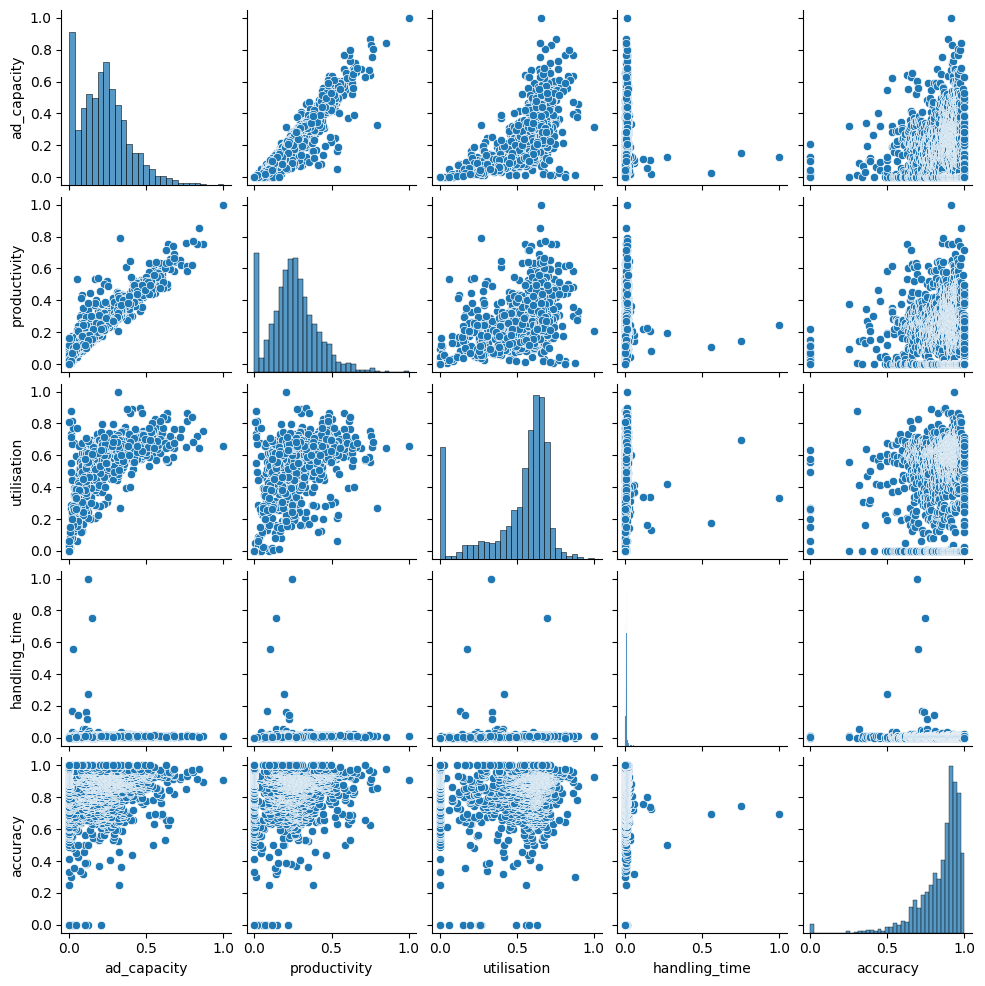

In [159]:
# Data viz of pairplots
sns.pairplot(scaled_df_m, height=2)
plt.show() 

### Gurobipy Optimisation

In [175]:
# initialise grb model
model_m = grb.Model("ads_optimisation")

# initialise weight variables for each column
w1_m = model_m.addVar(lb=0.0001, ub=10000, vtype=GRB.CONTINUOUS, name="w1")
w2_m = model_m.addVar(lb=0.0001, ub=10000, vtype=GRB.CONTINUOUS, name="w2")
w3_m = model_m.addVar(lb=0.0001, ub=10000, vtype=GRB.CONTINUOUS, name="w3")
w4_m = model_m.addVar(lb=0.0001, ub=10000, vtype=GRB.CONTINUOUS, name="w4")
w5_m = model_m.addVar(lb=0.0001, ub=10000, vtype=GRB.CONTINUOUS, name="w4")
w6_m = model_m.addVar(lb=0.0001, ub=1, vtype=GRB.CONTINUOUS, name="placeholder")

In [176]:
# store column values as list
capacity = scaled_df_m['ad_capacity'].tolist()
accuracy = scaled_df_m['accuracy'].tolist()
utilisation = scaled_df_m['utilisation'].tolist()
productivity = scaled_df_m['productivity'].tolist()
handling_time = scaled_df_m['handling_time'].tolist()

# initialise lists to store variable scores
capacity_scores = []
prod_scores = []
util_scores = []
handle_time_scores = []
accuracy_scores = []
final_score = []

# for each moderator
for i in range(len(accuracy)):

    # construct MLR eqn
    model_m.setObjective(
        expr = w1_m * capacity[i] + w2_m * accuracy[i] + utilisation[i] * w3_m + w4_m * productivity[i] - handling_time[i] * w5_m,
        sense = GRB.MAXIMIZE
    )

    # add weight constraints to rank importance of each variable
    model_m.addConstr(w1_m >= w2_m + 0.0001, name="w1_gt_w2")
    model_m.addConstr(w2_m >= w5_m + 0.0001, name="w2_gt_w3")
    model_m.addConstr(w5_m >= w3_m + 0.0001, name="w3_gt_w4")
    model_m.addConstr(w3_m >= w4_m, name="w3_gt_w4")
    model_m.addConstr(w4_m >= w6_m, name="w5_gt_w6")

    # Add upper and lower bound constraints for each variable
    model_m.addConstr(w1_m * capacity[i] + w2_m * accuracy[i] + utilisation[i] * w3_m + w4_m * productivity[i] - handling_time[i] * w5_m <= 1, name=f"upper_bound_{i}")
    model_m.addConstr(w1_m * capacity[i] + w2_m * accuracy[i] + utilisation[i] * w3_m + w4_m * productivity[i] - handling_time[i] * w5_m >= 0, name=f"lower_bound_{i}")

    model_m.update()
    model_m.optimize()

    # Check if an optimal solution was found
    if model_m.status == GRB.OPTIMAL:
        # Retrieve and print the optimal values of decision variables
        optimal_w1 = w1_m.x
        optimal_w2 = w2_m.x
        optimal_w3 = w3_m.x
        optimal_w4 = w4_m.x
        optimal_w5 = w5_m.x

        # Retrieve and print the optimal objective value
        optimal_objective_value = model_m.objVal

        capacity_scores.append(optimal_w1)
        accuracy_scores.append(optimal_w2)
        util_scores.append(optimal_w3)
        prod_scores.append(optimal_w4)
        handle_time_scores.append(optimal_w5)
        final_score.append(optimal_objective_value)

        print(i)
    else:
        print("No optimal solution found.")

Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (mac64[arm])

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 7 rows, 6 columns and 20 nonzeros
Model fingerprint: 0x2003a558
Coefficient statistics:
  Matrix range     [9e-03, 1e+00]
  Objective range  [9e-03, 6e-01]
  Bounds range     [1e-04, 1e+04]
  RHS range        [1e-04, 1e+00]
Presolve removed 5 rows and 4 columns
Presolve time: 0.00s
Presolved: 2 rows, 2 columns, 4 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0000000e+00   0.000000e+00   0.000000e+00      0s
       0    1.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective  1.000000000e+00
0
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (mac64[arm])

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 14 rows, 6 colu

In [177]:
# initialise output df for moderators
m_checker = pd.DataFrame()

m_checker['ad_capacity'] = capacity_scores
m_checker['productivity'] = prod_scores
m_checker['utilisation'] = util_scores
m_checker['handling_time'] = handle_time_scores
m_checker['accuracy'] = accuracy_scores
m_checker['final'] = final_score

m_checker.head(20)

,ad_capacity,productivity,utilisation,handling_time,accuracy,final
0,1.748129,0.0001,0.000100,0.000200,1.748029,1.000000
1,1.774527,0.0001,0.000100,1.774327,1.774427,0.437888
2,0.839862,0.0001,0.839562,0.839662,0.839762,1.000000
3,1.748129,0.0001,0.000100,0.000200,1.748029,0.709536
4,1.774527,0.0001,0.000100,1.774327,1.774427,0.590884
5,1.748129,0.0001,0.000100,0.000200,1.748029,0.716655
6,1.774527,0.0001,0.000100,1.774327,1.774427,0.681212
7,1.448384,0.0001,0.000100,1.448184,1.448284,1.000000
8,1.448384,0.0001,0.000100,1.448184,1.448284,0.807147
9,1.448384,0.0001,0.000100,1.448184,1.448284,0.703083


<Axes: >

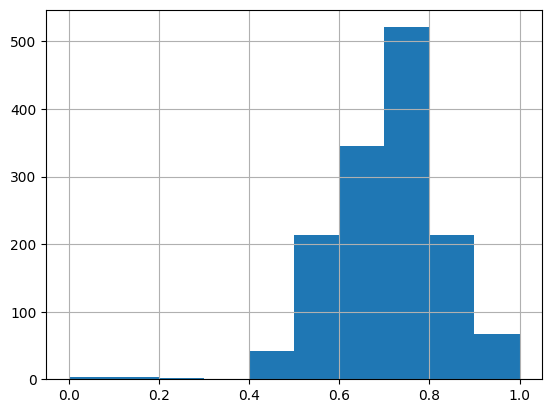

In [178]:
# visualise distribution
m_checker["final"].hist()

In [76]:
# output moderator data with final score as a csv
moderators_df["final_score"] = m_checker['final']
moderators_df.to_csv('intermediate/moderators_data.csv', index=False)